In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [6]:
!wget https://github.com/ReDialData/website/raw/data/redial_dataset.zip
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2025-10-03 11:30:06--  https://github.com/ReDialData/website/raw/data/redial_dataset.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ReDialData/website/data/redial_dataset.zip [following]
--2025-10-03 11:30:06--  https://raw.githubusercontent.com/ReDialData/website/data/redial_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5765261 (5.5M) [application/zip]
Saving to: ‘redial_dataset.zip’

redial_dataset.zip  100%[===================>]   5.50M  --.-KB/s    in 0.02s   

2025-10-03 11:30:06 (281 MB/s) - ‘redial_dataset.zip’ saved [5765261/5765261]

--2025-10-03 11:30:06--  http://

In [3]:
!unzip ml-latest-small.zip
!unzip redial_dataset.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
Archive:  redial_dataset.zip
  inflating: movies_with_mentions.csv  
  inflating: test_data.jsonl         
  inflating: train_data.jsonl        


In [7]:
!python scripts/split-redial.py redial/

In [8]:
!mv redial/test_data.jsonl redial/test_data

In [10]:
!python scripts/split-movielens.py ml-latest-small/

In [69]:
class ReDialAnalyzer:
    def __init__(self):
        self.conversations = []
    
    def load_data(self):
        with open("redial/train_data","r",encoding="utf-8") as f:
            for line in f:
                self._process_conversation(json.loads(line))
        
    def _process_conversation(self, conv_data):
        """Procesa una conversación individual"""
        messages = conv_data.get('messages', [])
        movie_mentions = conv_data.get('movieMentions', {})
        if isinstance(movie_mentions, list):
            movie_mentions = {str(i): movie for i, movie in enumerate(movie_mentions)}
        # Extraer información
        conv_info = {
            'conv_id': conv_data.get('conversationId', ''),
            'num_turns': len(messages),
            'messages': messages,
            'movie_mentions': movie_mentions,
            'items_mentioned': len(movie_mentions),
            'initiator_id': conv_data.get('initiatorWorkerId', ''),
            'respondent_id': conv_data.get('respondentWorkerId', ''),
            'initiator_questions': conv_data.get('initiatorQuestions', {}),
            'respondent_questions': conv_data.get('respondentQuestions', {})
        }
        
        self.conversations.append(conv_info)
    
    def analyze_conversation_length(self):
        """Analiza la distribución de longitud de conversaciones"""
        lengths = [conv['num_turns'] for conv in self.conversations]
        
        stats = {
            'mean': np.mean(lengths),
            'median': np.median(lengths),
            'std': np.std(lengths),
            'min': np.min(lengths),
            'max': np.max(lengths),
            'q25': np.percentile(lengths, 25),
            'q75': np.percentile(lengths, 75)
        }
        
        print("\n" + "="*60)
        print("ANÁLISIS DE LONGITUD DE CONVERSACIONES")
        print("="*60)
        print(f"Total de conversaciones: {len(lengths)}")
        print(f"Promedio de turnos: {stats['mean']:.2f}")
        print(f"Mediana de turnos: {stats['median']:.2f}")
        print(f"Desviación estándar: {stats['std']:.2f}")
        print(f"Rango: [{stats['min']}, {stats['max']}]")
        print(f"Cuartiles: Q1={stats['q25']:.1f}, Q3={stats['q75']:.1f}")
        
        return lengths, stats
    
    def analyze_items_mentioned(self):
        """Analiza el número de ítems (películas) mencionados por conversación"""
        items_counts = [conv['items_mentioned'] for conv in self.conversations]
        
        avg_items = np.mean(items_counts)
        total_unique_movies = len(set([
            movie_id for conv in self.conversations 
            for movie_id in conv['movie_mentions'].keys()
        ]))
        
        print("\n" + "="*60)
        print("ÍTEMS MENCIONADOS (PELÍCULAS)")
        print("="*60)
        print(f"Promedio de películas por conversación: {avg_items:.2f}")
        print(f"Mediana: {np.median(items_counts):.2f}")
        print(f"Total de películas únicas en el dataset: {total_unique_movies}")
        print(f"Máximo de películas en una conversación: {max(items_counts)}")
        
        return items_counts, avg_items
    
    def visualize_results(self, lengths,items_counts):
        """Crea visualizaciones completas de los análisis"""
        fig = plt.figure(figsize=(18, 12))
        
        # 1. Histograma de longitud de conversaciones
        ax1 = plt.subplot(3, 3, 1)
        plt.hist(lengths, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
        plt.xlabel('Número de Turnos', fontsize=10)
        plt.ylabel('Frecuencia', fontsize=10)
        plt.title('Distribución de Longitud de Conversaciones', fontsize=12, fontweight='bold')
        plt.axvline(np.mean(lengths), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(lengths):.1f}')
        plt.axvline(np.median(lengths), color='orange', linestyle='--', linewidth=2, label=f'Mediana: {np.median(lengths):.1f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Distribución de ítems mencionados
        ax2 = plt.subplot(3, 3, 2)
        plt.hist(items_counts, bins=max(items_counts), edgecolor='black', alpha=0.7, color='coral')
        plt.xlabel('Número de Películas Mencionadas', fontsize=10)
        plt.ylabel('Frecuencia', fontsize=10)
        plt.title('Películas Mencionadas por Conversación', fontsize=12, fontweight='bold')
        plt.axvline(np.mean(items_counts), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(items_counts):.1f}')
        plt.legend()
        plt.grid(True, alpha=0.3)

In [70]:
redial = ReDialAnalyzer()
redial.load_data()


ANÁLISIS DE LONGITUD DE CONVERSACIONES
Total de conversaciones: 8004
Promedio de turnos: 18.21
Mediana de turnos: 17.00
Desviación estándar: 5.38
Rango: [1, 116]
Cuartiles: Q1=15.0, Q3=21.0

ÍTEMS MENCIONADOS (PELÍCULAS)
Promedio de películas por conversación: 5.29
Mediana: 5.00
Total de películas únicas en el dataset: 5618
Máximo de películas en una conversación: 17


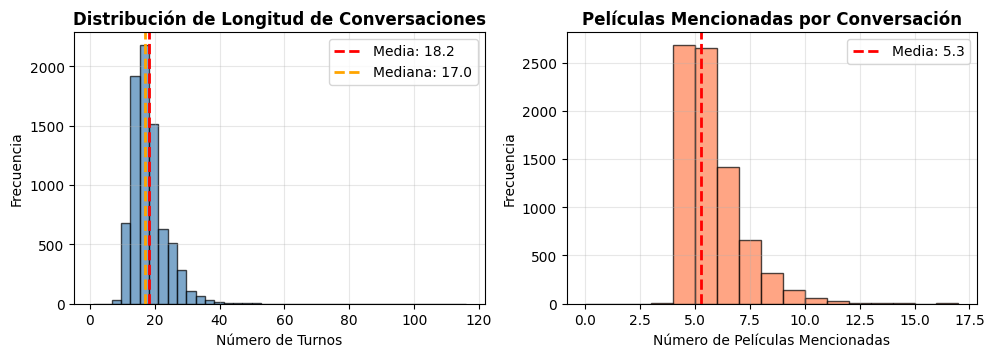

In [71]:
lengths = redial.analyze_conversation_length()
items = redial.analyze_items_mentioned()
redial.visualize_results(lengths[0],items[0])